[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lisuex/Machine-Learning2025/blob/main/Lab02.ipynb)

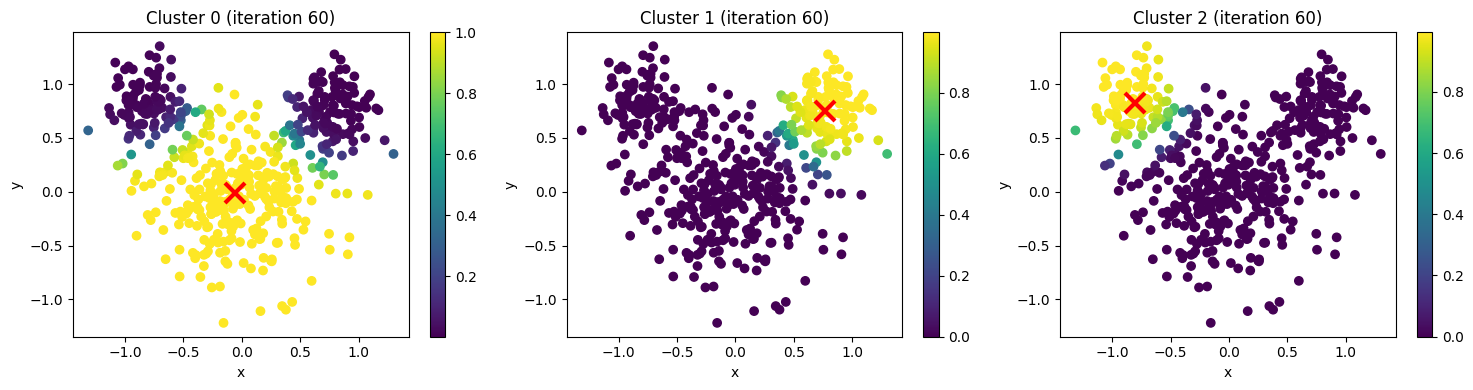

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# SECTION 1: Generate the "mouse" dataset
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

# ----------------------------------------------------------------------
# SECTION 2: Initialize EM for 3 Gaussian mixtures
# ----------------------------------------------------------------------
K = 3
np.random.seed(42)  # again for reproducibility

# Mixture weights, means, covariances
pi = np.ones(K) / K
mu = np.random.randn(K, d)
Sigma = np.array([np.eye(d) for _ in range(K)])

# ----------------------------------------------------------------------
# SECTION 3: Define functions for E-step & M-step
# ----------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian pdf value at x, given mean and cov.
    x is (d, ) vector, mean is (d, ), cov is (d, d).
    """
    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def e_step(data, pi, mu, Sigma):
    """
    E-step: compute the responsibilities resp[n, k] = p(z_n=k | x_n, theta).
    """
    N, _ = data.shape
    K = len(pi)
    resp = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            resp[n, k] = pi[k] * gaussian_pdf(data[n], mu[k], Sigma[k])
        resp[n, :] /= np.sum(resp[n, :])  # normalize

    return resp

def m_step(data, resp):
    """
    M-step: given responsibilities, update pi, mu, Sigma.
    """
    N, d_ = data.shape
    K = resp.shape[1]

    Nk = np.sum(resp, axis=0)  # shape (K,)

    # Update pi
    pi_new = Nk / N

    # Update mu
    mu_new = np.zeros((K, d_))
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k].reshape(-1,1)*data, axis=0) / Nk[k]

    # Update Sigma
    Sigma_new = []
    for k in range(K):
        S_k = np.zeros((d_, d_))
        for n in range(N):
            diff = data[n] - mu_new[k]
            S_k += resp[n, k] * np.outer(diff, diff)
        S_k /= Nk[k]
        Sigma_new.append(S_k)
    Sigma_new = np.array(Sigma_new)

    return pi_new, mu_new, Sigma_new

# ----------------------------------------------------------------------
# SECTION 4: Run EM for 60 iterations
# ----------------------------------------------------------------------
nr_iterations = 60

# Run EM for 60 iterations
for i in range(nr_iterations):
    resp = e_step(data_X, pi, mu, Sigma)
    pi, mu, Sigma = m_step(data_X, resp)

# ----------------------------------------------------------------------
# SECTION 7: plot the final state
# ----------------------------------------------------------------------
resp_final = e_step(data_X, pi, mu, Sigma)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for k in range(K):
    sc = axes[k].scatter(data_X[:,0], data_X[:,1], c=resp_final[:, k], cmap='viridis')
    axes[k].set_title(f'Cluster {k} (iteration {nr_iterations})')
    axes[k].set_xlabel('x')
    axes[k].set_ylabel('y')
    # Plot for the cluster center: "X" in red
    cp = axes[k].plot(mu[k,0], mu[k,1], 'rx', markersize=14, mew=3)
    # Add a colorbar
    plt.colorbar(sc, ax=axes[k])

plt.tight_layout()
plt.show()



**Primary Question**

Number of grid points assigned to each cluster: [1807  215  140]


<ipython-input-2-75043b1ecae3>:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


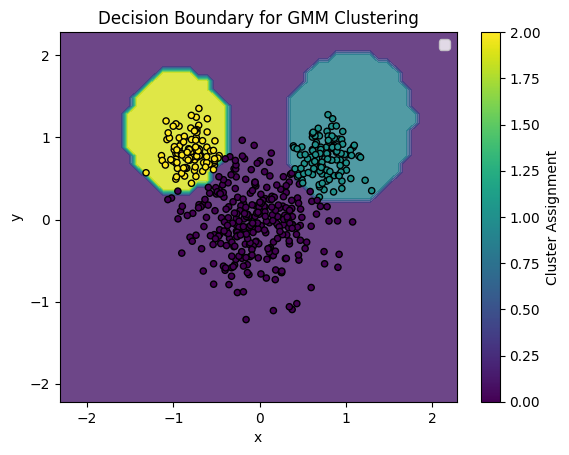

In [2]:
# Create decision boundary based on: https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07

min1, max1 = data_X[:, 0].min() - 1, data_X[:, 0].max() + 1
min2, max2 = data_X[:, 1].min() - 1, data_X[:, 1].max() + 1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1, r2))

resp_grid = e_step(grid, pi, mu, Sigma)
yhat = np.argmax(resp_grid, axis=1)

zz = yhat.reshape(xx.shape)

cluster_counts = np.bincount(yhat)
print("Number of grid points assigned to each cluster:", cluster_counts)

# Plot the decision boundary
plt.contourf(xx, yy, zz, alpha=0.8, cmap='viridis')

# Plot the original data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=np.argmax(resp_final, axis=1), cmap='viridis', s=20, edgecolor='k')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary for GMM Clustering')
plt.legend()
plt.colorbar(label='Cluster Assignment')
plt.show()

# The only strange thing I can see is the thing that whole background is in cluster 0,
# but looking on how the input data were created, that makes sense.

**Secondary Question**

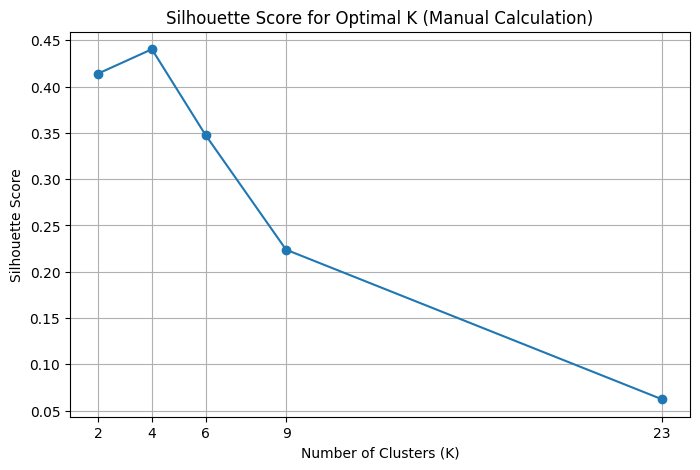

In [3]:
# We can try different K values from potential_K_array
# and check for which K the silhouette_score is the biggest
from scipy.spatial.distance import cdist

def silhouette_score_manual(data, labels):
    n = len(data)
    clusters = np.unique(labels)
    silhouette_values = np.zeros(n)

    for i in range(n):
        cluster = labels[i]
        same_cluster_indices = np.where(labels == cluster)[0]
        if len(same_cluster_indices) > 1:
            a_i = np.mean(cdist([data[i]], data[same_cluster_indices]))
        else:
            a_i = 0

        b_i_values = []
        for other_cluster in clusters:
            if other_cluster != cluster:
                other_cluster_indices = np.where(labels == other_cluster)[0]
                b_i_values.append(np.mean(cdist([data[i]], data[other_cluster_indices])))
        b_i = np.min(b_i_values) if b_i_values else 0  # If no other clusters, b(i) = 0

        if a_i == 0 and b_i == 0:
            s_i = 0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i)

        silhouette_values[i] = s_i
    return np.mean(silhouette_values)


potential_K_array = [2,3,4,6,9,23]
silhouette_scores = []

for k in potential_K_array:
    pi = np.ones(k) / k
    mu = np.random.randn(k, 2)
    Sigma = np.array([np.eye(2) for _ in range(k)])

    # Run EM for 60 iterations
    for _ in range(60):
        resp = e_step(data_X, pi, mu, Sigma)
        pi, mu, Sigma = m_step(data_X, resp)

    labels = np.argmax(resp, axis=1)

    score = silhouette_score_manual(data_X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(potential_K_array, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K (Manual Calculation)')
plt.xticks(potential_K_array)
plt.grid()
plt.show()